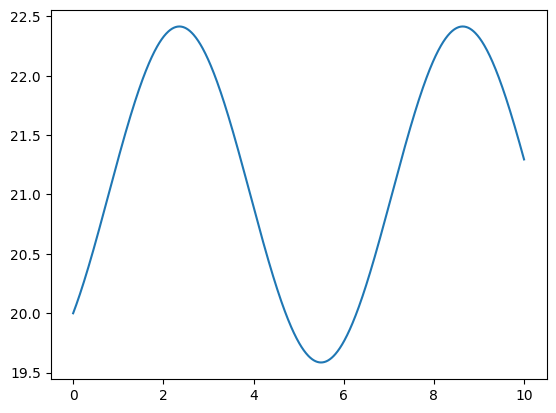

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# y' = sin(x) + cos(x) という微分方程式を解く
class Diff_Eq:
    
    bias = 20.0
    
    x0 = 0.0
    
    @staticmethod
    def y_prime(x, y):
        return torch.sin(x) + torch.cos(x)
    
    @classmethod
    def y0(cls):
        return 0.0 + cls.bias
    
    @classmethod
    def y(cls, x):
        return torch.sin(x) - torch.cos(x) + 1.0 +  cls.bias

# y' = - x y^2 という微分方程式を解く
# class Diff_Eq:
    
#     x0 = 1.
    
#     @staticmethod
#     def y_prime(x, y):
#         return - x * y ** 2
    
#     @staticmethod
#     def y0():
#         return 1.0 
    
#     @staticmethod
#     def y(x):
#         return 2 / (1 + x ** 2) 


# y' = - 2 x y という微分方程式を解く
# class Diff_Eq:
    
#     x0 = 0.0
    
#     @staticmethod
#     def y_prime(x, y):
#         return - 2 * x * y
    
#     @staticmethod
#     def y0():
#         return 1.0
    
#     @staticmethod
#     def y(x):
#         return torch.exp(- x ** 2) 
    
# 解を描画
x = torch.linspace(0, 10, 1000)
y = Diff_Eq.y(x)
plt.plot(x, y)
plt.show()


In [2]:
class EqDataset(torch.utils.data.Dataset):
    
    def __init__(self,x_from=0, x_to=20,length = 300000):
        
        self.x_from = x_from
        self.x_to = x_to
        self.length = length
        
        return 
    
    def __len__(self):
        
        return self.length
    
    def __getitem__(self, idx):
        
        x = torch.rand(1) * (self.x_to - self.x_from) + self.x_from
        
        return x
    
dataset = EqDataset()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

In [3]:



class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        def build_layers(in_features, out_features):
            return nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.Tanh()
            )
        
        self.fc = nn.Sequential(
            build_layers(1, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            nn.Linear(20, 1)
        )
        
        self.bias = nn.Parameter(torch.tensor([Diff_Eq.y0()]))
        # self.bias = Diff_Eq.y0()
        
        return 
    
    def forward(self, x):
        
        out = self.fc(x)
        
        
        out = out + self.bias 
        
        return out

    

epoch: 0


100%|██████████| 300/300 [00:05<00:00, 57.46it/s]


loss_mse: 0.8154835917552312
loss_init: 0.26357454164116156
loss_total: 0.8181193387508392


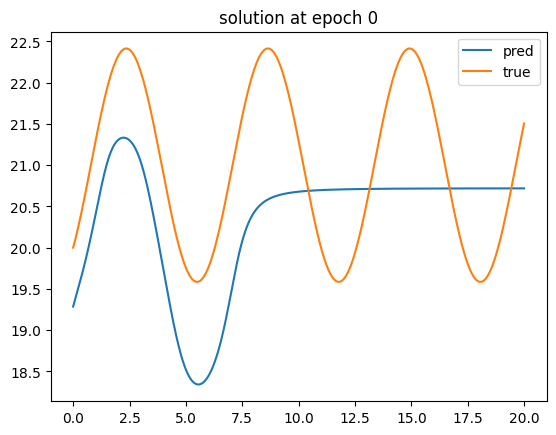

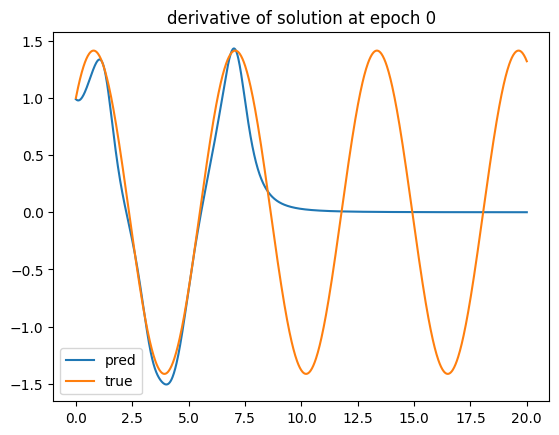

epoch: 1


100%|██████████| 300/300 [00:04<00:00, 69.21it/s]


loss_mse: 0.5029374528924624
loss_init: 0.10534994821258199
loss_total: 0.5039909516771635


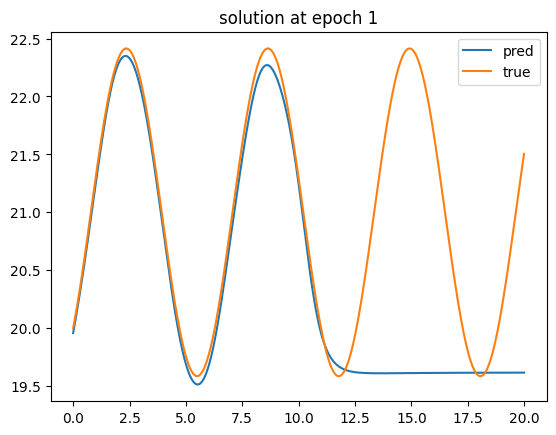

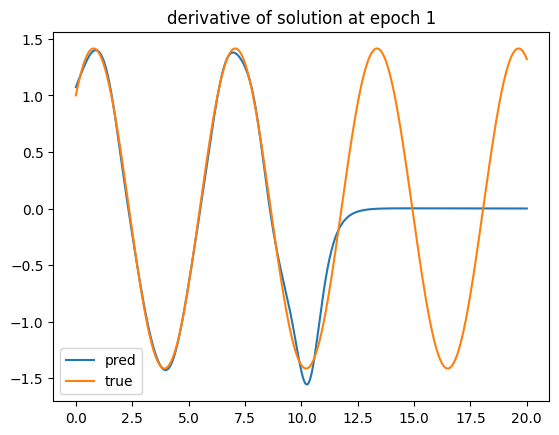

epoch: 2


100%|██████████| 300/300 [00:04<00:00, 67.25it/s]

loss_mse: 0.29565593510866167
loss_init: 0.02256468282098164
loss_total: 0.29588158244887985


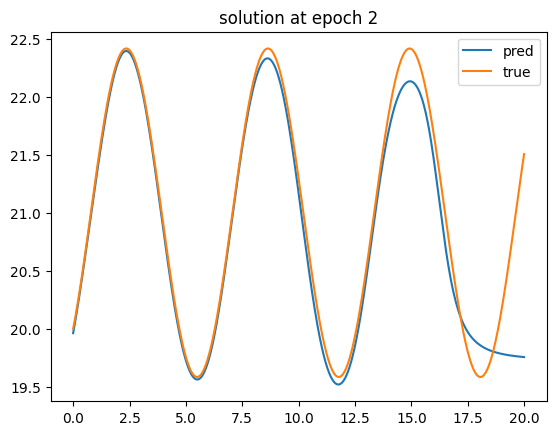

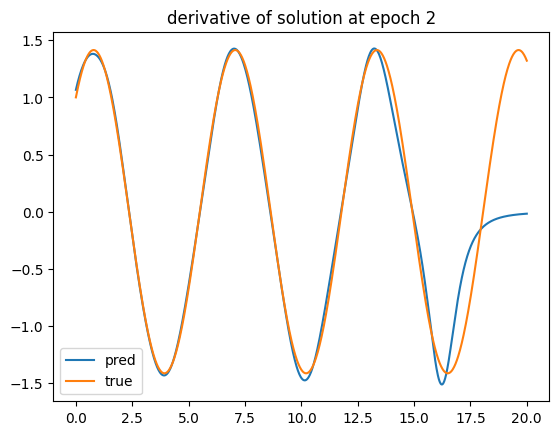

epoch: 3


100%|██████████| 300/300 [00:04<00:00, 67.83it/s]


loss_mse: 0.06985162502659174
loss_init: 0.004588630144523146
loss_total: 0.06989751138258725


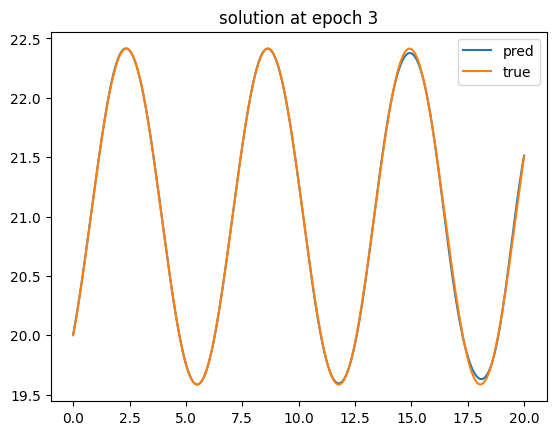

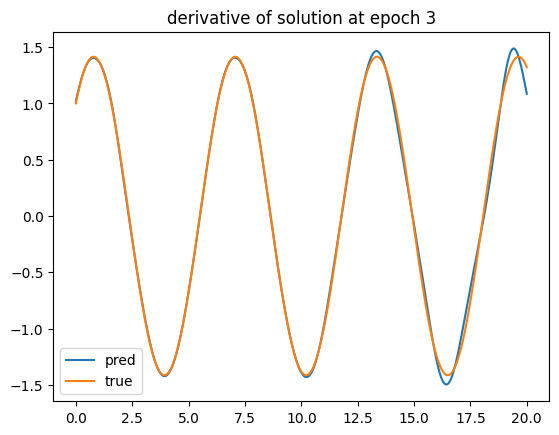

epoch: 4


100%|██████████| 300/300 [00:04<00:00, 67.82it/s]


loss_mse: 0.0012976192564625915
loss_init: 3.6066756413977905e-05
loss_total: 0.0012979799268456797


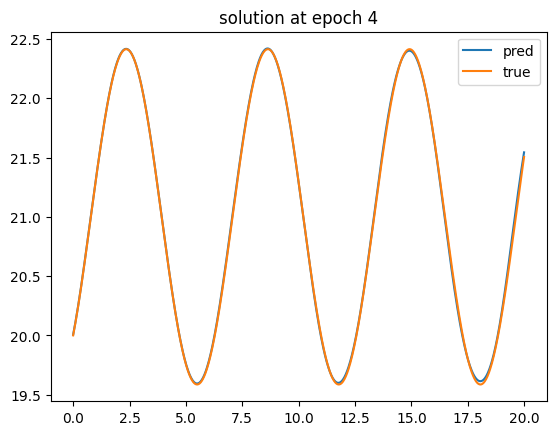

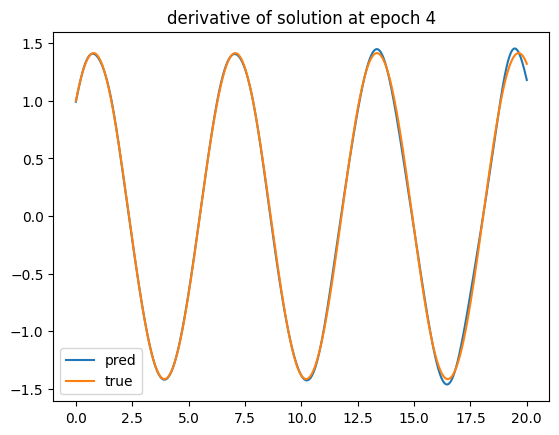

epoch: 5


100%|██████████| 300/300 [00:04<00:00, 68.20it/s]

loss_mse: 0.0005464071166837432
loss_init: 3.3772324774569523e-05
loss_total: 0.0005467448412673548


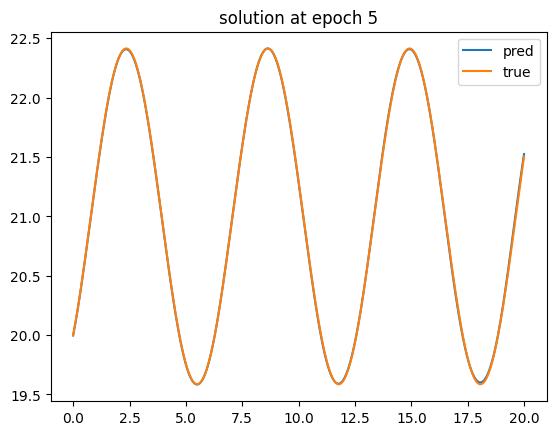

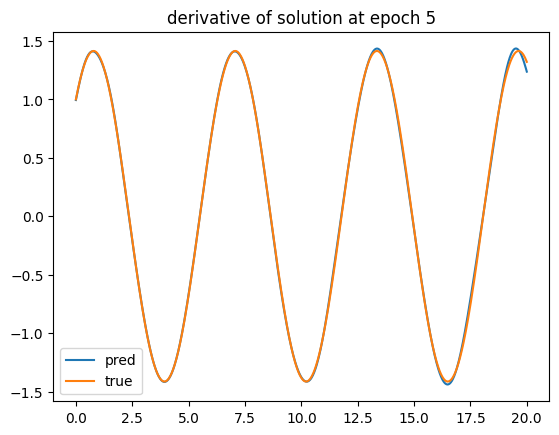

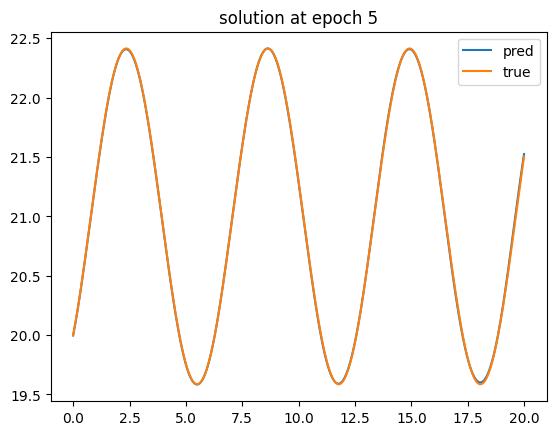

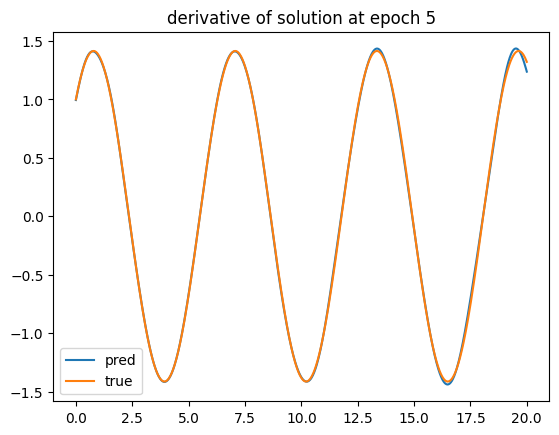

In [4]:
from traceback import print_tb




model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 6

loss_list = {
    "mse": [],
    "init": [],
    "total": []
}

for epoch in range(num_epochs):
    
    print(f"epoch: {epoch}")
    
    loss_list["mse"].append(0)
    loss_list["init"].append(0)
    loss_list["total"].append(0)
    
    from tqdm import tqdm
    
    for x in tqdm(dataloader):
        
        
        optimizer.zero_grad()
        
        x : torch.Tensor = x.to(device)
        x.requires_grad = True
        y_prime : torch.Tensor = Diff_Eq.y_prime(x, Diff_Eq.y(x))
        
        y_pred: torch.Tensor = model(x)
        

        y_prime_pred = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
        
        # print(y_prime_pred)
        
        loss_mse = F.mse_loss(y_prime_pred, y_prime)

        
        y0_pred  = model(torch.tensor([[Diff_Eq.x0]]).to(device))
        y0_true = torch.tensor([[Diff_Eq.y0()]]).to(device)
        loss_init = (y0_pred - y0_true) ** 2
        
        loss = loss_mse + loss_init * 0.01
        loss.backward()
        
        optimizer.step()
        
        loss_list["mse"][-1] += loss_mse.item()
        loss_list["init"][-1] += loss_init.item()
        loss_list["total"][-1] += loss.item()
    
    loss_list["mse"][-1] /= len(dataloader)
    loss_list["init"][-1] /= len(dataloader)
    loss_list["total"][-1] /= len(dataloader)
    
    print(f"loss_mse: {loss_list['mse'][-1]}")
    print(f"loss_init: {loss_list['init'][-1]}")
    print(f"loss_total: {loss_list['total'][-1]}")
    
    val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
    val_x.requires_grad = True
    val_y = model(val_x)
    
    plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
    plt.legend() 
    plt.title(f"solution at epoch {epoch}")
    plt.show()
    
    
    # 微分値についても描画
    val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
    plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
    plt.legend()
    plt.title(f"derivative of solution at epoch {epoch}")
    plt.show()


val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
val_x.requires_grad = True
val_y = model(val_x)

plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
plt.legend() 
plt.title(f"solution at epoch {epoch}")
plt.show()


# 微分値についても描画
val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
plt.legend()
plt.title(f"derivative of solution at epoch {epoch}")
plt.show()


# 初期値補正バイアスを活用した場合

In [8]:




model: Net = Net()


model.bias = nn.Parameter(torch.tensor([0.0]))
model.bias.requires_grad = False


model.to(device)







Net(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (5): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (6): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)

# 初期値補正バイアスを利用しなかった場合

epoch: 0


100%|██████████| 300/300 [00:04<00:00, 64.55it/s]


loss_mse: 1.0049129947026572
loss_init: 223.95947909037272
loss_total: 3.244507741133372


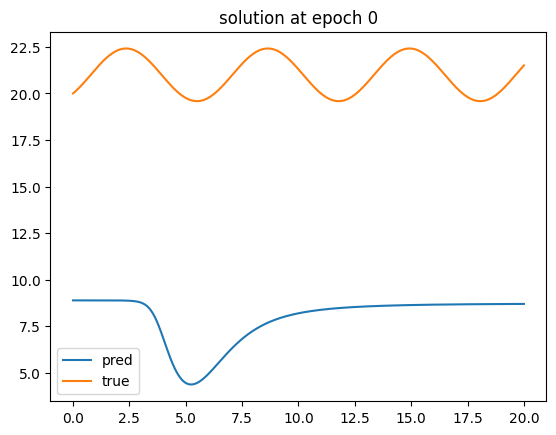

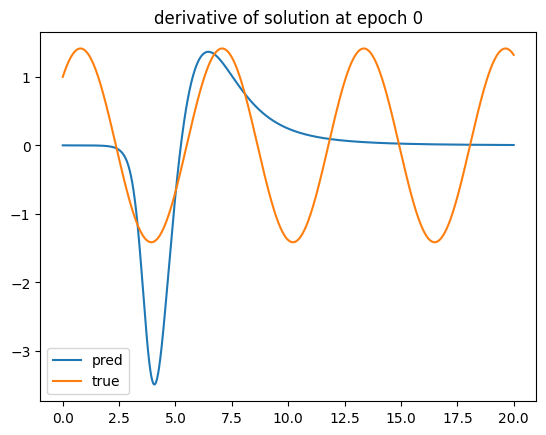

epoch: 1


100%|██████████| 300/300 [00:04<00:00, 67.34it/s]


loss_mse: 0.8194161814451217
loss_init: 76.28144622802735
loss_total: 1.5822306315104167


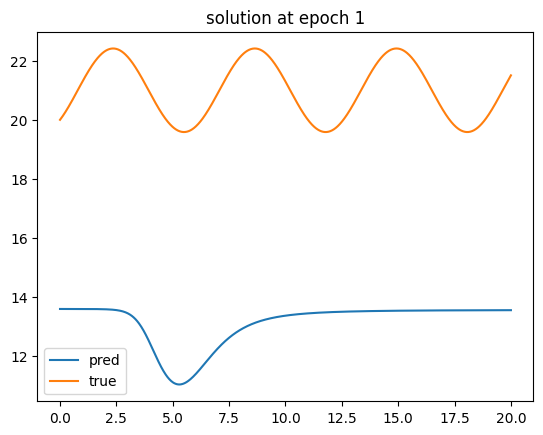

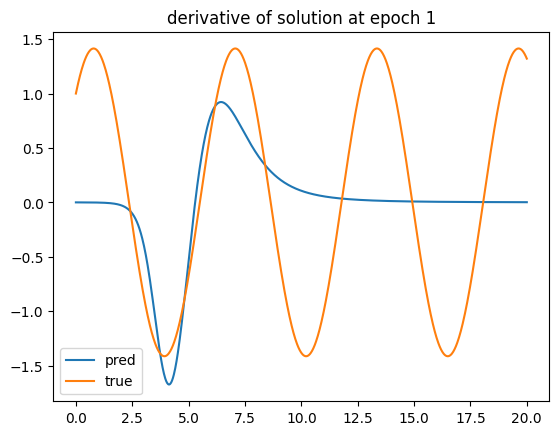

epoch: 2


100%|██████████| 300/300 [00:04<00:00, 66.94it/s]


loss_mse: 0.8411542969942093
loss_init: 22.979796209335326
loss_total: 1.070952252348264


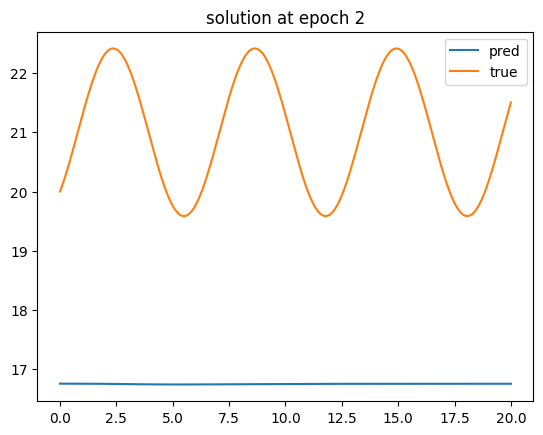

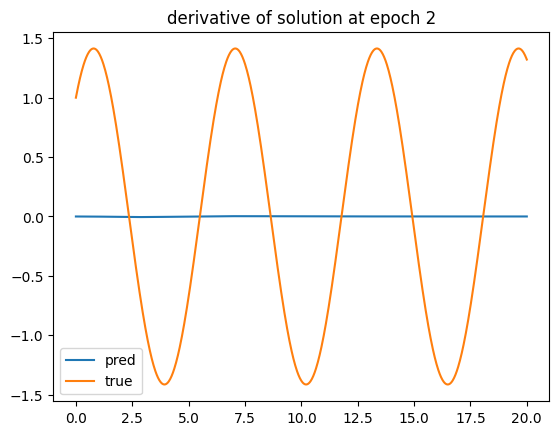

epoch: 3


100%|██████████| 300/300 [00:04<00:00, 67.37it/s]


loss_mse: 0.8836068830887477
loss_init: 5.237161289453507
loss_total: 0.9359784917036692


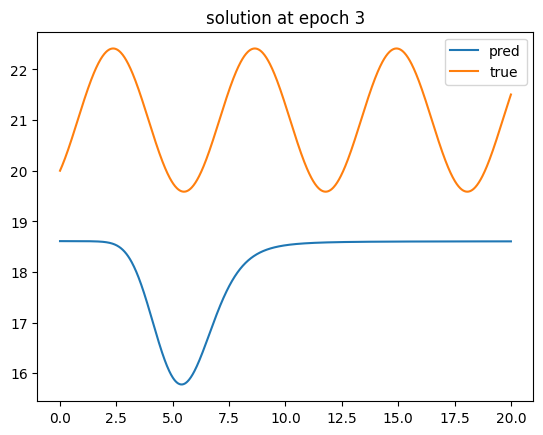

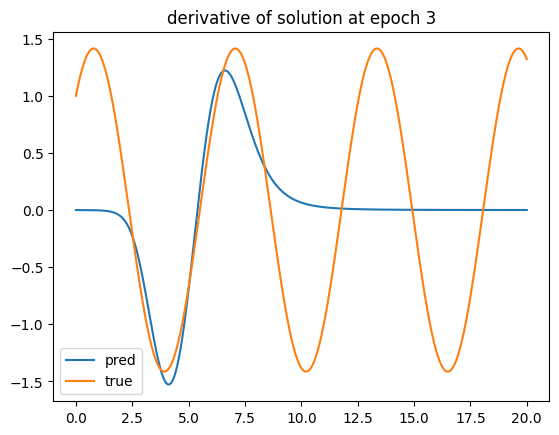

epoch: 4


100%|██████████| 300/300 [00:04<00:00, 67.43it/s]


loss_mse: 0.9744432999690373
loss_init: 0.848626837482055
loss_total: 0.9829295700788498


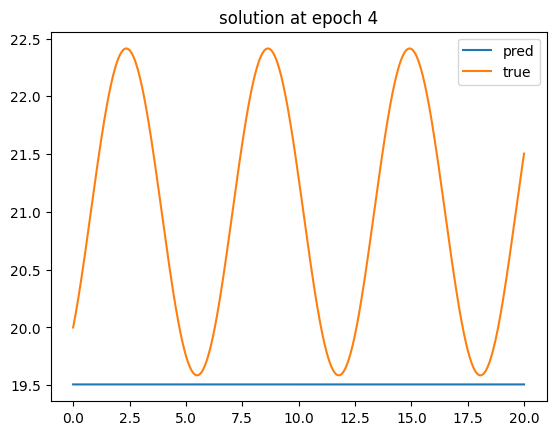

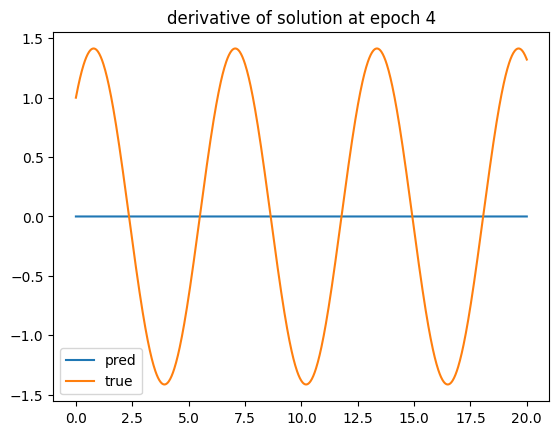

epoch: 5


100%|██████████| 300/300 [00:04<00:00, 65.96it/s]


loss_mse: 1.0406214561065037
loss_init: 0.09132802774508794
loss_total: 1.0415347395340602


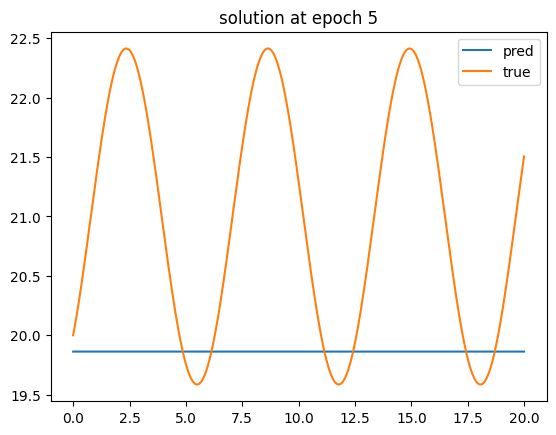

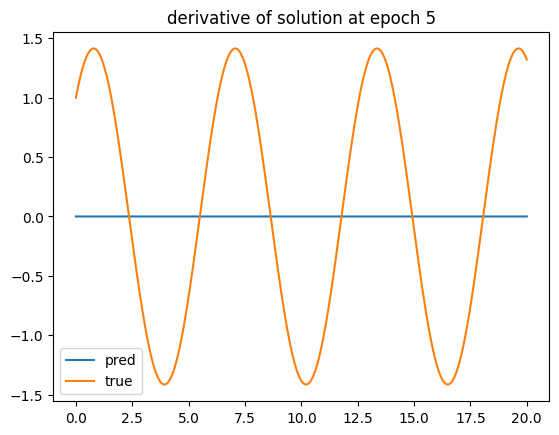

epoch: 6


100%|██████████| 300/300 [00:04<00:00, 68.14it/s]

loss_mse: 1.0404549050331116
loss_init: 0.0060962976338729885
loss_total: 1.0405158652861912


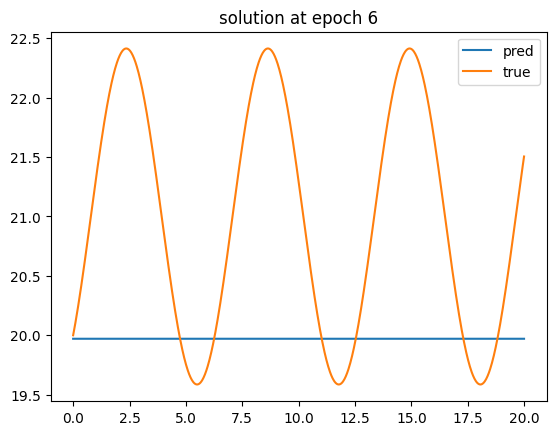

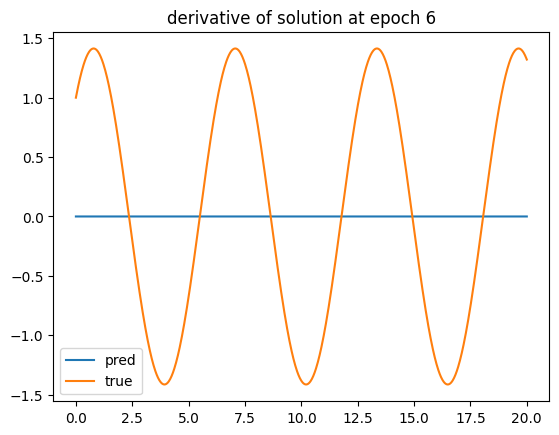

epoch: 7


100%|██████████| 300/300 [00:04<00:00, 68.41it/s]


loss_mse: 1.0424443091948827
loss_init: 0.00023807855735261303
loss_total: 1.042446689605713


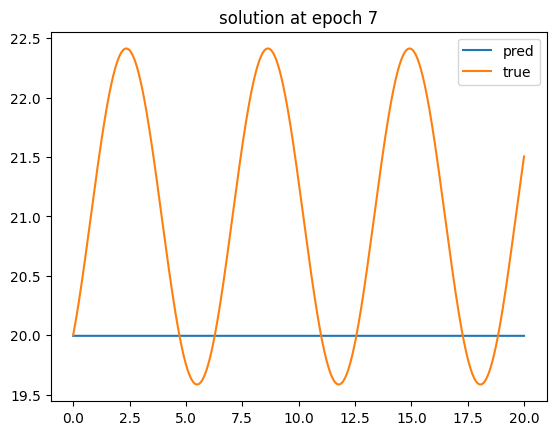

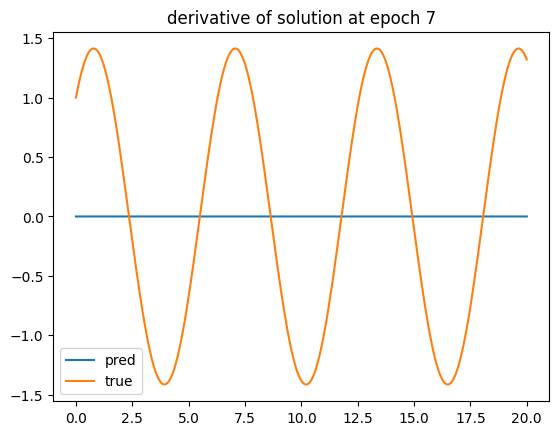

epoch: 8


100%|██████████| 300/300 [00:04<00:00, 66.55it/s]


loss_mse: 1.0409956824779512
loss_init: 4.982416891531708e-06
loss_total: 1.0409957243998846


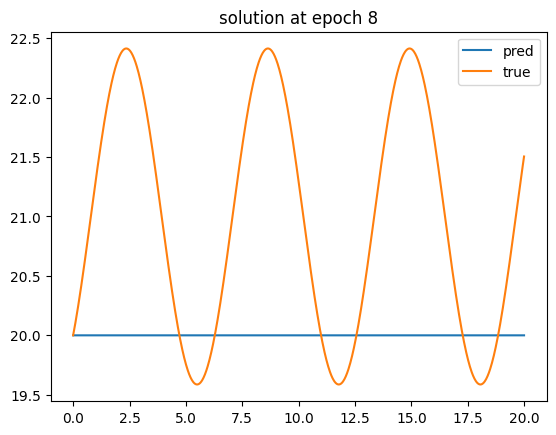

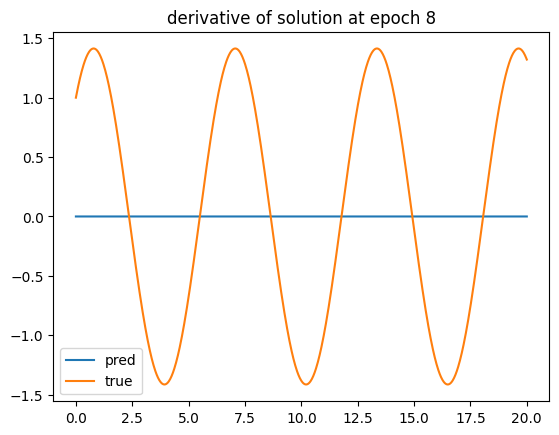

epoch: 9


100%|██████████| 300/300 [00:04<00:00, 67.87it/s]


loss_mse: 1.0423499421278635
loss_init: 4.904415012182047e-08
loss_total: 1.0423499421278635


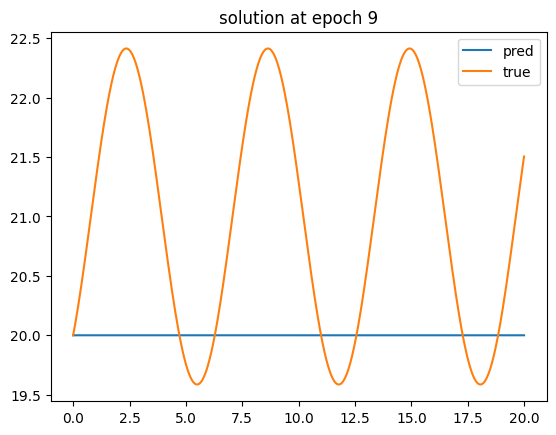

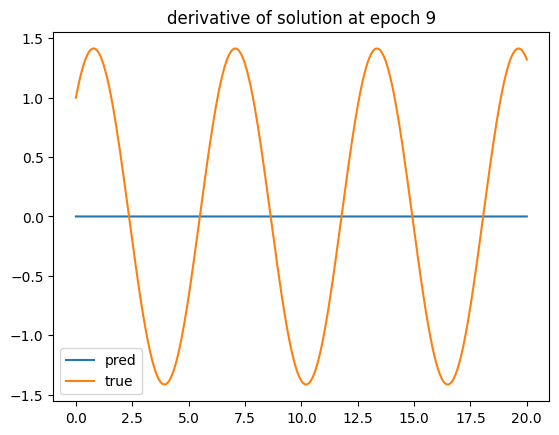

epoch: 10


100%|██████████| 300/300 [00:04<00:00, 68.07it/s]


loss_mse: 1.0412840121984481
loss_init: 5.646143108606338e-10
loss_total: 1.0412840121984481


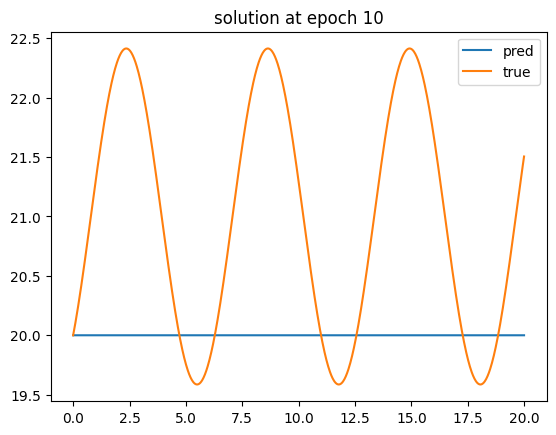

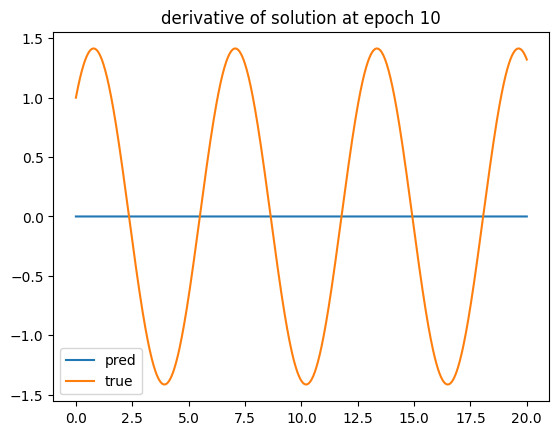

epoch: 11


100%|██████████| 300/300 [00:04<00:00, 66.30it/s]


loss_mse: 1.0420123120148976
loss_init: 5.38469369833668e-10
loss_total: 1.0420123120148976


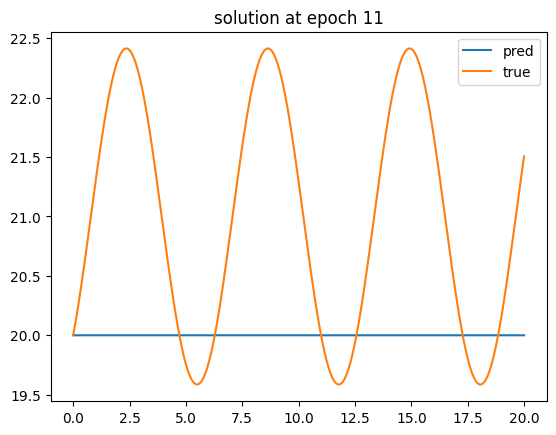

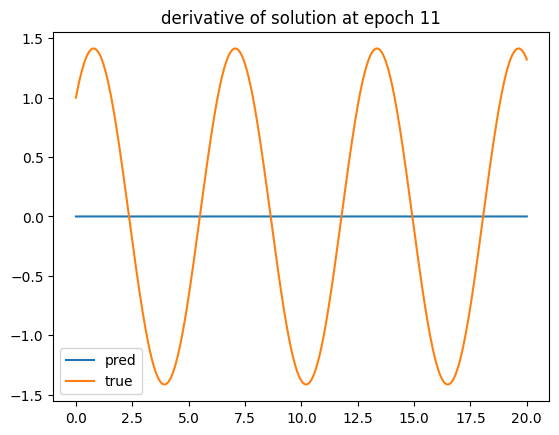

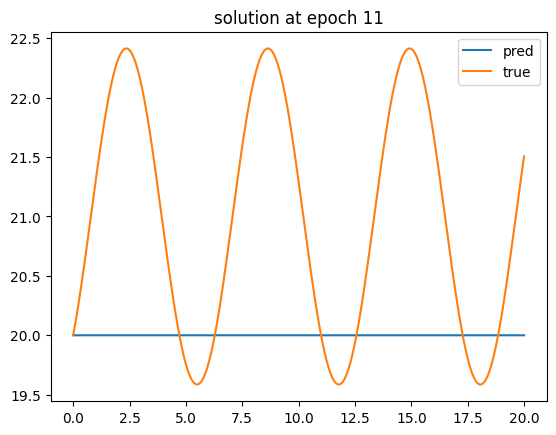

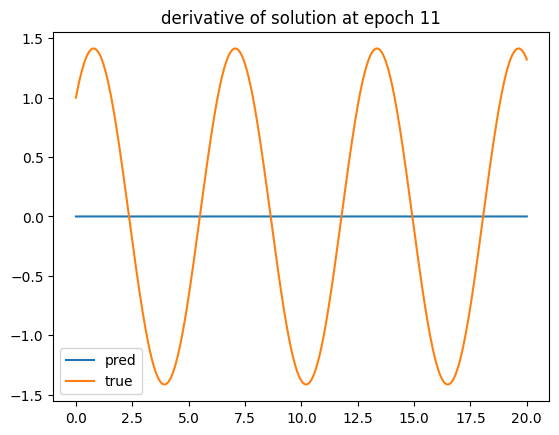

In [9]:
from traceback import print_tb

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 12

loss_list = {
    "mse": [],
    "init": [],
    "total": []
}

for epoch in range(num_epochs):
    
    print(f"epoch: {epoch}")
    
    loss_list["mse"].append(0)
    loss_list["init"].append(0)
    loss_list["total"].append(0)
    
    from tqdm import tqdm
    
    for x in tqdm(dataloader):
        
        
        optimizer.zero_grad()
        
        x : torch.Tensor = x.to(device)
        x.requires_grad = True
        y_prime : torch.Tensor = Diff_Eq.y_prime(x, Diff_Eq.y(x))
        
        y_pred: torch.Tensor = model(x)
        

        y_prime_pred = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
        
        # print(y_prime_pred)
        
        loss_mse = F.mse_loss(y_prime_pred, y_prime)

        
        y0_pred  = model(torch.tensor([[Diff_Eq.x0]]).to(device))
        y0_true = torch.tensor([[Diff_Eq.y0()]]).to(device)
        loss_init = (y0_pred - y0_true) ** 2
        
        loss = loss_mse + loss_init * 0.01
        loss.backward()
        
        optimizer.step()
        
        loss_list["mse"][-1] += loss_mse.item()
        loss_list["init"][-1] += loss_init.item()
        loss_list["total"][-1] += loss.item()
    
    loss_list["mse"][-1] /= len(dataloader)
    loss_list["init"][-1] /= len(dataloader)
    loss_list["total"][-1] /= len(dataloader)
    
    print(f"loss_mse: {loss_list['mse'][-1]}")
    print(f"loss_init: {loss_list['init'][-1]}")
    print(f"loss_total: {loss_list['total'][-1]}")
    
    val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
    val_x.requires_grad = True
    val_y = model(val_x)
    
    plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
    plt.legend() 
    plt.title(f"solution at epoch {epoch}")
    plt.show()
    
    
    # 微分値についても描画
    val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
    plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
    plt.legend()
    plt.title(f"derivative of solution at epoch {epoch}")
    plt.show()


val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
val_x.requires_grad = True
val_y = model(val_x)

plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
plt.legend() 
plt.title(f"solution at epoch {epoch}")
plt.show()


# 微分値についても描画
val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
plt.legend()
plt.title(f"derivative of solution at epoch {epoch}")
plt.show()


In [11]:
model.bias

Parameter containing:
tensor([0.], device='cuda:0')